# Training Convolutional Neural Network

In [1]:
import os 
import cv2
import numpy as np
from tqdm import tqdm

REBUILD_DATA = False

class DogsVSCats():
    IMG_SIZE = 50
    CATS = "PetImages/Cat"
    DOGS = "PetImages/Dog"
    LABELS = {CATS: 0, DOGS: 1}
    training_data = []
    catcount = 0
    dogcount = 0
    
    def make_training_data(self):
        for label in self.LABELS: 
            print(label)
            for f in tqdm(os.listdir(label)): # tqdm is progress bar
                try:
                    path = os.path.join(label, f) # Set up path
                    # Read in image in grayscale
                    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
                    # Resize
                    img = cv2.resize(img,(self.IMG_SIZE,self.IMG_SIZE))
                    # Set up training data
                    self.training_data.append([np.array(img), np.eye(2)[self.LABELS[label]]])

                    # Count samples from each class
                    if label == self.CATS:
                        self.catcount += 1
                    elif label == self.DOGS:
                        self.dogcount += 1
                except Exception as e:
                    pass
                    # print(str(e))
        
        np.random.shuffle(self.training_data)
        np.save("training_data.npy", self.training_data)
        print("Cats: ", self.catcount)
        print("Dogs: ", self.dogcount)

if REBUILD_DATA:
    dogsvcats = DogsVSCats()
    dogsvcats.make_training_data()

In [2]:
training_data = np.load("training_data.npy", allow_pickle=True)

In [3]:
print(len(training_data))

24946


# Model Here

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 5) # 2D Convolutional  Layers
        self.conv2 = nn.Conv2d(32, 64, 5)
        self.conv3 = nn.Conv2d(64, 128, 5)
        
        x = torch.randn(50,50).view(-1,1,50,50)
        self._to_linear = None
        self.convs(x)
        
        self.fc1 = nn.Linear(self._to_linear,512)
        self.fc2 = nn.Linear(512,2)
        
    def convs(self,x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2,2))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2,2))
        x = F.max_pool2d(F.relu(self.conv3(x)), (2,2))
        # print(x[0].shape)
        
        if self._to_linear is None:
            self._to_linear = np.prod(x[0].shape)
        return x
    
    def forward(self,x):
        x = self.convs(x)
        x = x.view(-1,self._to_linear)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.softmax(x, dim=1)

net = Net()

In [5]:
import torch.optim as optim

optimizer = optim.Adam(net.parameters(), lr = 1e-3)
loss_function = nn.MSELoss()

X = torch.Tensor([i[0] for i in training_data]).view(-1,50,50)
X = X/255.0
y = torch.Tensor([i[1] for i in training_data])

VAL_PCT = 0.1
val_size = int(len(X)*VAL_PCT)
print(val_size)

2494


In [6]:
# Slices
train_X = X[:-val_size]
train_y = y[:-val_size]

test_X = X[-val_size:]
test_y = y[-val_size:]

print(len(train_X))
print(len(test_X))

22452
2494


In [9]:
BATCH_SIZE = 100
EPOCHS = 5

for epoch in range(EPOCHS):
    for i in tqdm(range(0,len(train_X), BATCH_SIZE)):
        # print(i, i+BATCH_SIZE)
        batch_X = train_X[i:i+BATCH_SIZE].view(-1,1,50,50)
        batch_y = train_y[i:i+BATCH_SIZE]
        
        # Zero the gradient
        net.zero_grad()
        outputs = net(batch_X)
        loss = loss_function(outputs,batch_y)
        loss.backward()
        optimizer.step()

    print(loss)

  0%|                                                                                          | 0/225 [00:00<?, ?it/s]

tensor(0.2401, grad_fn=<MseLossBackward>)


  0%|                                                                                          | 0/225 [00:00<?, ?it/s]

tensor(0.2279, grad_fn=<MseLossBackward>)


  0%|                                                                                          | 0/225 [00:00<?, ?it/s]

tensor(0.1857, grad_fn=<MseLossBackward>)


  0%|                                                                                          | 0/225 [00:00<?, ?it/s]

tensor(0.1472, grad_fn=<MseLossBackward>)


100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [01:37<00:00,  2.30it/s]

tensor(0.1552, grad_fn=<MseLossBackward>)


In [10]:
correct = 0
total = 0
with torch.no_grad():
    for i in tqdm(range(len(test_X))):
        real_class = torch.argmax(test_y[i])
        net_out = net(test_X[i].view(-1,1,50,50))[0]
        predicted_class = torch.argmax(net_out)
        if predicted_class == real_class:
            correct += 1
        total += 1
print("Accuracy: ", round(correct/total,3))

100%|█████████████████████████████████████████████████████████████████████████████| 2494/2494 [00:07<00:00, 313.52it/s]

Accuracy:  0.711


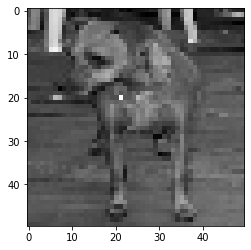

tensor(1)


In [32]:
import matplotlib.pyplot as plt

# print(test_X[0])
plt.imshow(test_X[8], cmap="gray")
plt.show()

# 0 -> Cat
# 1 -> Dog
print(torch.argmax(net(test_X[8].view(-1,1,50,50))[0]))